# Анализ гипотез для увеличения выручки интернет-магазина

**Цель проекта:**  
Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.
Необходимо изучить:
- приоретизацию гипотез, 
- результат А/В теста. 

**Имеющиеся данные**  
- гипотезы, позволяющие увеличить выручку,  
- данные по датам о количестве посетителей в каждой из групп (А и В), 
- данные о совершенных пользователями покупках (в разрезе пользователя и даты).     

**Ход исследования**  
- приоретизация гипотез
- предобработка данных о пользователях и их действиях
- анализ А/В теста:  
    - анализ кумулятивной выручки по группам, 
    - анализ среднего куммулятивного чека по группам, 
    - анализ куммулятивной конверсии по группам,
    - определения аномальных пользователей (по числу заказов и сумме заказа)
    - определение статистической значимости различий конверсии:  
        - по сырым данным
        - по очищенным данным
    - определение статистической значимости различий среднего чека:  
        - по сырым данным
        - по очищенным данным        
- вывод по проекту

In [1]:
%load_ext lab_black

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats as st
import numpy as np
import datetime as dt
import scipy.stats as stats
from functools import reduce

In [3]:
pd.set_option("max_colwidth", 400)

## Приоритизация гипотез

In [4]:
local_path = "./"
server_path = "/datasets/"
file = "hypothesis.csv"
try:
    data_hypothesis = pd.read_csv(f"{local_path}{file}")
except:
    data_hypothesis = pd.read_csv(f"{server_path}{file}")

In [5]:
data_hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


Для удобства обращения переименовала столбцы - убрала заглавные буквы.

In [6]:
data_hypothesis.columns = [c.lower() for c in data_hypothesis.columns.values]

In [7]:
data_hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


В файле представлены 9 гипотез по увеличению выручки интернет-магазина.  
Для выбора оптимальных применим поочередно фреймворки ICE и RICE и определим наиболее приоритетные из них.

In [8]:
data_hypothesis["ICE"] = (
    (data_hypothesis["impact"] * data_hypothesis["confidence"])
    / data_hypothesis["efforts"]
).round(3)
data_hypothesis.iloc[:, [0, 5]].sort_values(by="ICE", ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000


Наиболее перспективные гипотезы по ICE это 9, 1 и 8 - их приоритет наибольший. 

In [9]:
data_hypothesis["RICE"] = (
    data_hypothesis["reach"] * data_hypothesis["impact"] * data_hypothesis["confidence"]
) / data_hypothesis["efforts"]
data_hypothesis.iloc[:, [0, 1, 6]].sort_values(by="RICE", ascending=False)

,hypothesis,reach,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,3.0


Наиболее перспективные гипотезы по RICE это 8, 3 и 1 - их приоритет наибольший. 

In [10]:
# построим график на котором будут видны изменения приоритета гипотеза при использовании разных фреймворков
data_ice = (
    pd.DataFrame(
        {
            "num": data_hypothesis.index,
            "ICE": (data_hypothesis["impact"] * data_hypothesis["confidence"])
            / data_hypothesis["efforts"],
        }
    )
    .round(3)
    .sort_values(
        by="ICE",
    )
    .reset_index(drop=True)
)
data_ice = data_ice.reset_index().rename(
    columns={"index": "position"},
)

data_rice = (
    pd.DataFrame(
        {
            "num": data_hypothesis.index,
            "RICE": (
                data_hypothesis["reach"]
                * data_hypothesis["impact"]
                * data_hypothesis["confidence"]
            )
            / data_hypothesis["efforts"],
        }
    )
    .sort_values(
        by="RICE",
    )
    .reset_index(drop=True)
)
data_rice = data_rice.reset_index().rename(columns={"index": "position"})

data_ice["coef"] = "ICE"
data_rice["coef"] = "RICE"

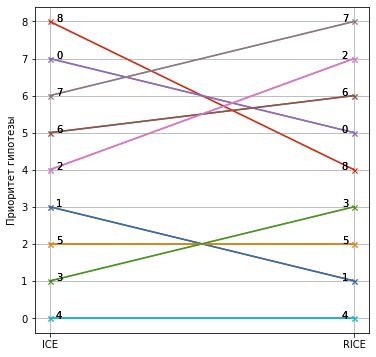

In [11]:
data_agg = data_ice.append(data_rice)

fig, ax = plt.subplots(1, figsize=(6, 6))

for i in data_agg.num:
    temp = data_agg[data_agg["num"] == i]

    plt.plot(
        temp.coef,
        temp.position,
        marker="x",
        markersize=5,
    )

    plt.text(0 + 0.02, temp.position.values[0], i)

    plt.text(1 - 0.02, temp.position.values[1], i, ha="right")

plt.ylabel("Приоритет гипотезы")
plt.grid()
plt.show()

__Вывод__

При сравнении приоритетов гипотез по ICE и RICE можно заметить, что 8 и 1 гипотезы (индексы 7 и 0) находятся в двух списках в топ-3, но на разных позициях.  
Изменение приоритизации при использовании разных фреймворков обусловлено разным набором компонент - в RICE используется дополнительный параметр reach, 
который показывает охват пользователей, которых коснутся изменения из проверяемых гипотез. По этой причине гипотеза 9 покинула тройку наиболее приоритетных - ее значение охвата составило 1, и это самое маленькое значение по сравнению с остальными гипотезами.  
Наиболее приоритетной гипотезой можно считать гипотезу 8 (индекс 7) *"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок"*. Предположим, что она была выбрана для проведения А/В теста. Далее проанализируем полученные результаты этого теста.

## Анализ A/B-теста

In [12]:
local_path = "./"
server_path = "/datasets/"
files = ["visitors", "orders"]
data_frames = []
for file in files:
    try:
        exec(f"data_{file} = pd.read_csv('{local_path}{file}.csv')")
        data_frames.append(f"data_{file}")
    except:
        exec(f"data_{file} = pd.read_csv('{server_path}{file}.csv')")
        data_frames.append(f"data_{file}")

In [13]:
for df in data_frames:
    print(df)
    locals().get(df).info()
    print("")
    print(locals().get(df).head())
    print("\n")

data_visitors
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB

         date group  visitors
0  2019-08-01     A       719
1  2019-08-02     A       619
2  2019-08-03     A       507
3  2019-08-04     A       717
4  2019-08-05     A       756


data_orders
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 

In [14]:
start_date = data_visitors["date"].astype("datetime64").dt.date.min()
end_date = data_visitors["date"].astype("datetime64").dt.date.max()
print(f"Дата начала теста: {start_date}\nДата окончания теста: {end_date}")

Дата начала теста: 2019-08-01
Дата окончания теста: 2019-08-31


In [15]:
usersA = data_orders.query('group == "A"')["visitorId"].unique()
usersB = data_orders.query('group == "B"')["visitorId"].unique()
intersection = np.intersect1d(usersA, usersB)
intersection.shape

(58,)

В данных есть пользователи которые попали при группировке в обе группы (58 человек). Правильным решением было бы их удалить, но т.к. таблица data_visitors уже не содержит данных по идентификаторам пользователей, то их удаление только из одной части данных (одной таблицы) может исказить общую картину.

### Анализ кумулятивной выручки по группам

In [16]:
# приведем данные к нужному типу и выделим день
data_orders["date"] = data_orders["date"].astype("datetime64").dt.day
data_visitors["date"] = data_visitors["date"].astype("datetime64").dt.day

Учитывая, что анализ данных ограничен только одним месяцем - августом, считаю более наглядно представлять дату только числом.

In [17]:
# сгруппируем данные по дате и группе
dates_groups = data_orders[["date", "group"]].drop_duplicates()
dates_groups.head()

,date,group
0,15,B
2,15,A
45,16,A
47,16,B
55,1,A


In [18]:
# подготовим данные для куммулятивной таблицы
# в разрезе даты и группы расчитаем количество уникальных пользователей, заказов и выручку
orders_agg = dates_groups.apply(
    lambda x: data_orders[
        np.logical_and(
            data_orders["date"] <= x["date"], data_orders["group"] == x["group"]
        )
    ].agg(
        {
            "date": "max",
            "group": "max",
            "transactionId": "nunique",
            "visitorId": "nunique",
            "revenue": "sum",
        }
    ),
    axis=1,
).sort_values(by=["date", "group"])

In [19]:
# в разрезе даты и группы определим число посетителей
visitors_agg = dates_groups.apply(
    lambda x: data_visitors[
        np.logical_and(
            data_visitors["date"] <= x["date"], data_visitors["group"] == x["group"]
        )
    ].agg({"date": "max", "group": "max", "visitors": "sum"}),
    axis=1,
).sort_values(by=["date", "group"])

In [20]:
cum_data = orders_agg.merge(
    visitors_agg, left_on=["date", "group"], right_on=["date", "group"]
)
cum_data.columns = ["date", "group", "orders", "buyers", "revenue", "visitors"]

cum_data.head()

,date,group,orders,buyers,revenue,visitors
0,1,A,24,20,148579,719
1,1,B,21,20,101217,713
2,2,A,44,38,242401,1338
3,2,B,45,43,266748,1294
4,3,A,68,62,354874,1845


In [21]:
cum_revenueA = cum_data[cum_data["group"] == "A"][["date", "revenue", "orders"]]
cum_revenueB = cum_data[cum_data["group"] == "B"][["date", "revenue", "orders"]]

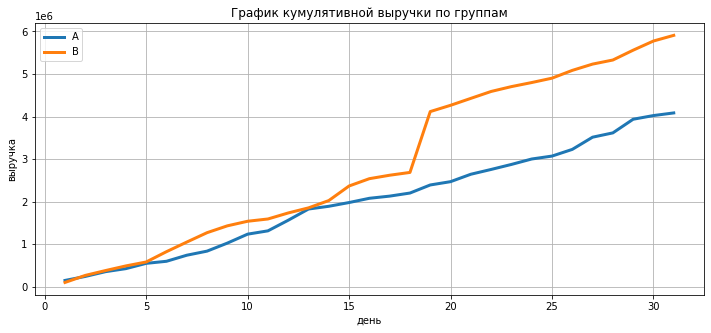

In [22]:
# построим график кумулятивной выручки по группам
plt.figure(figsize=(12, 5))
plt.xlabel("день")
plt.ylabel("выручка")
plt.grid()
plt.plot(cum_revenueA["date"], cum_revenueA["revenue"], label="A", lw=3)
plt.plot(cum_revenueB["date"], cum_revenueB["revenue"], label="B", lw=3)
plt.title("График кумулятивной выручки по группам")
plt.legend()
plt.show()

На графике кумулятивной выручки по группам можно заметить, что сегмент B опередил сегмент А на 5 день теста (5 августа) и далее продолжился его рост. Отдельно можно отметить резкий скачок 18 числа, вероятно связанный с заказом на крупную сумму либо резко увеличилось число покупателей. 


### Анализ кумулятивного среднего чека по группам

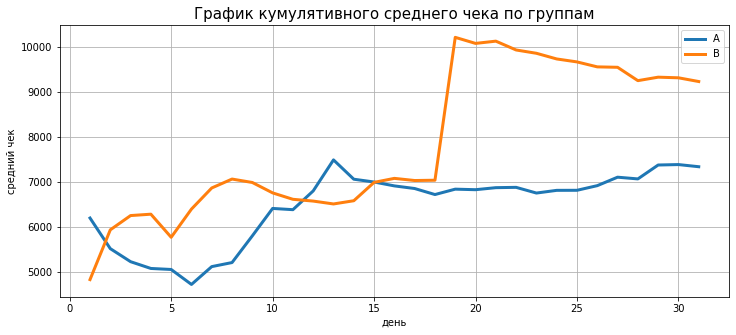

In [23]:
plt.figure(figsize=(12, 5))
plt.xlabel("день")
plt.ylabel("средний чек")
plt.grid()
plt.plot(
    cum_revenueA["date"],
    cum_revenueA["revenue"] / cum_revenueA["orders"],
    label="A",
    lw=3,
)
plt.plot(
    cum_revenueB["date"],
    cum_revenueB["revenue"] / cum_revenueB["orders"],
    label="B",
    lw=3,
)
plt.title("График кумулятивного среднего чека по группам", size=15)
plt.legend()
plt.show()

График кумулятивного среднего чека по группам показывает, что на протяжении всего периода наблюдения средний чек группы В выше, среднего чека группы А, за исключением краткого отрезка (12-15 дни). В районе 18 числа наблюдается резкий подъем показателя по группе В, в то время как по группе А два менее заметных подъема в районе 8 и 11 числа. После этих выбросов значения по обеим группам относительно стабилизировались.

### Анализ относительного изменения кумулятивного среднего чека группы B к группе A

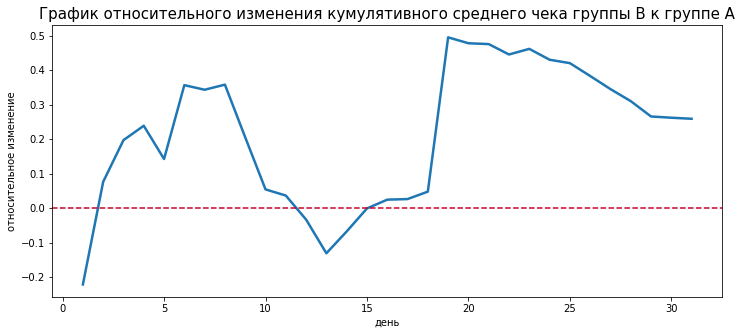

In [24]:
plt.figure(figsize=(12, 5))
cum_revenue = cum_revenueA.merge(
    cum_revenueB, left_on="date", right_on="date", how="left", suffixes=["A", "B"]
)
plt.plot(
    cum_revenue["date"],
    (cum_revenue["revenueB"] / cum_revenue["ordersB"])
    / (cum_revenue["revenueA"] / cum_revenue["ordersA"])
    - 1,
    lw=2.5,
)
plt.axhline(y=0, color="#c70226", linestyle="--")
plt.title(
    "График относительного изменения кумулятивного среднего чека группы B к группе A",
    size=15,
)
plt.xlabel("день")
plt.ylabel("относительное изменение")
plt.show()

Большую часть времени проведения теста кумулятивный средний чек группы В выше значений теста А, однако наблюдаются резкие колебания графика в период с 9 по 15 день теста. Аномальные по стоимости заказы в эти даты привели к снижению показателя по группе В и росту показателя по группе А.

### Анализ кумулятивной конверсии по группам

In [25]:
# расчитаем конверсию по каждой из групп
cum_data["conversion"] = cum_data["orders"] / cum_data["visitors"]
cum_dataA = cum_data[cum_data["group"] == "A"]
cum_dataB = cum_data[cum_data["group"] == "B"]

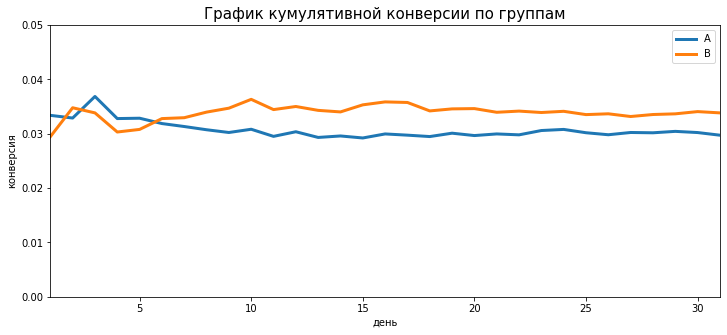

In [26]:
plt.figure(figsize=(12, 5))
plt.plot(cum_dataA["date"], cum_dataA["conversion"], label="A", lw=3)
plt.plot(cum_dataB["date"], cum_dataB["conversion"], label="B", lw=3)
plt.axis([1, 31, 0, 0.05])
plt.xlabel("день")
plt.ylabel("конверсия")
plt.legend()
plt.title("График кумулятивной конверсии по группам", size=15)
plt.show()

В начале теста (до 5 дня) конверсия группы А была выше конверсии группы В, далее ситуация стала прямо противоположной, при этом показатели конверсии обеих групп постепенно стабилизировались (после 10 дня теста).

### Анализ относительного изменения кумулятивной конверсии группы B к группе A

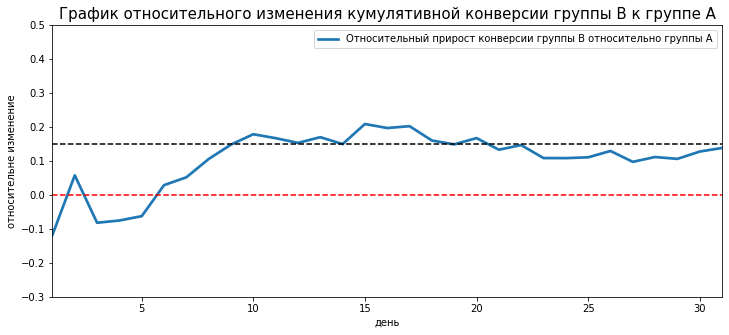

In [27]:
cum_conversions = cum_dataA[["date", "conversion"]].merge(
    cum_dataB[["date", "conversion"]],
    left_on="date",
    right_on="date",
    how="left",
    suffixes=["A", "B"],
)

plt.figure(figsize=(12, 5))
plt.plot(
    cum_conversions["date"],
    cum_conversions["conversionB"] / cum_conversions["conversionA"] - 1,
    label="Относительный прирост конверсии группы B относительно группы A",
    lw=2.7,
)
plt.legend()
plt.axhline(y=0, color="red", linestyle="--")
plt.axhline(y=0.15, color="black", linestyle="--")
plt.axis(plt.axis([1, 31, -0.3, 0.5]))
plt.title(
    "График относительного изменения кумулятивной конверсии группы B к группе A",
    size=15,
)
plt.xlabel("день")
plt.ylabel("относительне изменение")
plt.show()

С пятого дня теста кумулятивная конверсия группы В превысила показатель группы А и далее зафиксировалась на уровне 15% его прироста.

### Анализ количества заказов по пользователям

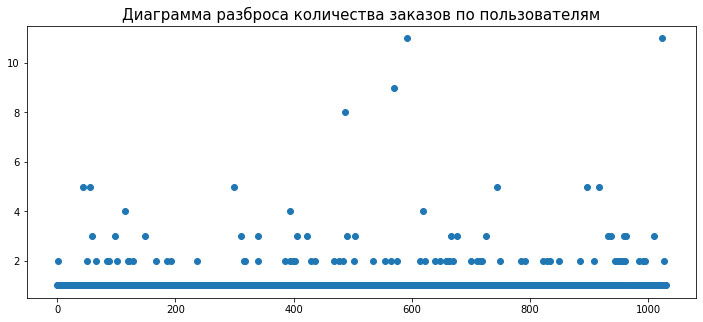

In [28]:
# построим диаграмму разброса количества заказов по пользователям для выявления аномалий
plt.figure(figsize=(12, 5))
orders_per_user = data_orders.groupby("visitorId", as_index=False).agg(
    {"transactionId": "nunique"}
)
orders_per_user.columns = ["visitorId", "orders"]
x_values = pd.Series(range(0, len(orders_per_user)))
plt.scatter(x=x_values, y=orders_per_user["orders"])
plt.title("Диаграмма разброса количества заказов по пользователям", size=15)
plt.show()

По диаграмме разброса количества пользователей можно сделать вывод, что наиболее часто встречающееся значение 1, второе по частоте 2. Пользователей с количеством заказов больше двух гораздо меньше.

### Определение границы количества заказов аномальных пользователей

In [29]:
percentiles = np.percentile(orders_per_user["orders"], [95, 99])
print(
    f"95-й перцентиль равен {percentiles[0]} \n99-й перцентиль равен {percentiles[1]}"
)

95-й перцентиль равен 2.0 
99-й перцентиль равен 4.0


Согласно расчетам 95 и 99 перцентиля не больше 5% пользователей совершают более 2 заказов, и только 1% пользователей более четырех.  
На основании этих вычислений границу аномальных значений можно принять как 3 заказа. 

### Анализ суммы заказов

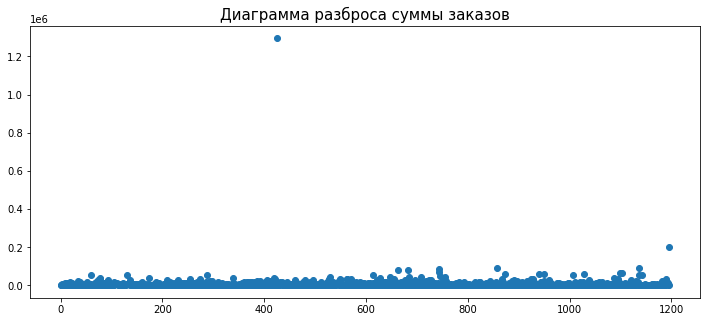

In [30]:
plt.figure(figsize=(12, 5))
x_values = pd.Series(range(0, len(data_orders["revenue"])))
plt.scatter(x_values, data_orders["revenue"])
plt.title("Диаграмма разброса суммы заказов", size=15)
plt.show()

Согласно диаграмме рассеяния основная масса заказов была на сумму не превышающую 150 000 единиц. Заказ свыше 200000 единиц, а также 1200000 единиц можно считать выбросами.

### Определение границы суммы аномальных заказов

In [31]:
percentiles = np.percentile(data_orders["revenue"], [95, 99])
print(
    "95-й перцентиль равен {:.2f} \n99-й перцентиль равен {:.2f}".format(*percentiles)
)

95-й перцентиль равен 28000.00 
99-й перцентиль равен 58233.20


Согласно расчетам 95 и 99 перцентиля не больше 5% пользователей совершают заказы на сумму свыше 28000 единиц, и только 1% пользователей более 58000 единиц.  
На основании этих вычислений границу аномальных значений можно принять как 30 000 единиц.

### Статистическая значимость различий в конверсии между группами по «сырым» данным

In [32]:
# рассчитаем куммулятивное число посетителей по группам и по дням
day_visitorsA = data_visitors[data_visitors["group"] == "A"][["date", "visitors"]]
day_visitorsA.columns = ["date", "date_visitorsA"]

cum_visitorsA = day_visitorsA.apply(
    lambda x: day_visitorsA[day_visitorsA["date"] <= x["date"]].agg(
        {"date": "max", "date_visitorsA": "sum"}
    ),
    axis=1,
)

cum_visitorsA.columns = ["date", "cum_visitorsA"]

In [33]:
day_visitorsB = data_visitors[data_visitors["group"] == "B"][["date", "visitors"]]
day_visitorsB.columns = ["date", "date_visitorsB"]

cum_visitorsB = day_visitorsB.apply(
    lambda x: day_visitorsB[day_visitorsB["date"] <= x["date"]].agg(
        {"date": "max", "date_visitorsB": "sum"}
    ),
    axis=1,
)

cum_visitorsB.columns = ["date", "cum_visitorsB"]

In [34]:
# рассчитаем куммулятивное число заказов и их сумму по группам и по дням
day_ordersA = (
    data_orders[data_orders["group"] == "A"][
        ["date", "transactionId", "visitorId", "revenue"]
    ]
    .groupby("date", as_index=False)
    .agg({"transactionId": pd.Series.nunique, "revenue": "sum"})
)

day_ordersA.columns = ["date", "date_ordersA", "date_revenueA"]

cum_ordersA = day_ordersA.apply(
    lambda x: day_ordersA[day_ordersA["date"] <= x["date"]].agg(
        {"date": "max", "date_ordersA": "sum", "date_revenueA": "sum"}
    ),
    axis=1,
).sort_values(by=["date"])

cum_ordersA.columns = [
    "date",
    "cum_ordersA",
    "cum_revenueA",
]

In [35]:
day_ordersB = (
    data_orders[data_orders["group"] == "B"][
        ["date", "transactionId", "visitorId", "revenue"]
    ]
    .groupby("date", as_index=False)
    .agg({"transactionId": pd.Series.nunique, "revenue": "sum"})
)

day_ordersB.columns = ["date", "date_ordersB", "date_revenueB"]

cum_ordersB = day_ordersB.apply(
    lambda x: day_ordersB[day_ordersB["date"] <= x["date"]].agg(
        {"date": "max", "date_ordersB": "sum", "date_revenueB": "sum"}
    ),
    axis=1,
).sort_values(by=["date"])
cum_ordersB.columns = [
    "date",
    "cum_ordersB",
    "cum_revenueB",
]

In [36]:
# сведем все полученные данные в одну таблицу для удобства использования
big_table = reduce(
    lambda left, right: pd.merge(left, right, on=["date"], how="left"),
    [
        day_visitorsA,
        day_visitorsB,
        cum_visitorsA,
        cum_visitorsB,
        day_ordersA,
        day_ordersB,
        cum_ordersA,
        cum_ordersB,
    ],
).reset_index(drop=True)

In [37]:
# получим информаци о количестве заказов каждого пользователя по группам
orders_per_userA = (
    data_orders[data_orders["group"] == "A"]
    .groupby("visitorId", as_index=False)
    .agg({"transactionId": pd.Series.nunique})
)

orders_per_userA.columns = ["visitorId", "orders"]

orders_per_userB = (
    data_orders[data_orders["group"] == "B"]
    .groupby("visitorId", as_index=False)
    .agg({"transactionId": pd.Series.nunique})
)

orders_per_userB.columns = ["visitorId", "orders"]

В качестве нулевой и альтернативной **гипотезы** для выяснения **статистической значимости различия конверсии** можно взять следующие утверждения:  
**Н0** "различий в конверсии между группами нет"  
**Н1** "различия в конверсии между группами есть".  
Анализ произведен по *"сырым" данным*.  

In [38]:
# проверим выдвинутые гипотезы рассчетами
sampleA = pd.concat(
    [
        orders_per_userA["orders"],
        pd.Series(
            0,
            index=np.arange(
                big_table["date_visitorsA"].sum() - len(orders_per_userA["orders"])
            ),
            name="orders",
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        orders_per_userB["orders"],
        pd.Series(
            0,
            index=np.arange(
                big_table["date_visitorsB"].sum() - len(orders_per_userB["orders"])
            ),
            name="orders",
        ),
    ],
    axis=0,
)

print(
    " p-value равно {0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]),
    "\n",
    "относительное различие в конверсии между группами {0:.3f}".format(
        (big_table["date_ordersB"].sum() / big_table["date_visitorsB"].sum())
        / (big_table["date_ordersA"].sum() / big_table["date_visitorsA"].sum())
        - 1
    ),
)

 p-value равно 0.01679 
 относительное различие в конверсии между группами 0.138


Полученное значение p-value 0.01679 намного меньше критического уровня статистической значимости (установленного для этого теста 0.05), значит нулевую гипотезу можно отвергнуть и следовательно различия в конверсии между группами есть (альтернативная гипотеза).  
Относительный прирост конверсии группы В к конверсии группы А составляет 13,8%, что довольно значительно.

### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

В качестве нулевой и альтернативной **гипотезы** для выяснения **статистической значимости различия суммы среднего чека** возьмем такие утверждения:  
**Н0** "различий в сумме среднего чека между группами нет"  
**Н1** "различия в сумме среднего чека между группами есть".  
Анализ произведен по *"сырым" данным*.

In [39]:
print(
    " p-value равно {0:.5f}".format(
        stats.mannwhitneyu(
            data_orders[data_orders["group"] == "A"]["revenue"],
            data_orders[data_orders["group"] == "B"]["revenue"],
        )[1]
    ),
    "\n",
    "относительное различие в среднем чеке между группами {0:.3f}".format(
        data_orders[data_orders["group"] == "B"]["revenue"].mean()
        / data_orders[data_orders["group"] == "A"]["revenue"].mean()
        - 1
    ),
)

 p-value равно 0.72929 
 относительное различие в среднем чеке между группами 0.259


Полученное значение p-value 0.72929 намного больше критического уровня статистической значимости (установленного для этого теста 0.05), значит нулевую гипотезу отвергнуть нельзя и следовательно различий сумме среднего между группами нет (нулевая гипотеза).  
Наблюдаемое отличие среднего чека группы В (на 25,9%) и аналогичного показателя группы А не является статистически значимым.

### Статистическая значимость различий в конверсии между группами по «очищенным» данным

Для дальнейших расчетов очистим "сырые" данные от аномальных значений числа заказов и суммы заказа:

In [40]:
orders_lim = np.percentile(orders_per_user["orders"], 95)
revenue_lim = np.percentile(data_orders["revenue"], 95)

users_many_orders = pd.concat(
    [
        orders_per_userA[orders_per_userA["orders"] > orders_lim]["visitorId"],
        orders_per_userB[orders_per_userB["orders"] > orders_lim]["visitorId"],
    ],
    axis=0,
)

users_exp_orders = data_orders[data_orders["revenue"] > revenue_lim]["visitorId"]

abnorm_users = (
    pd.concat([users_many_orders, users_exp_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)

In [41]:
sampleA_filter = pd.concat(
    [
        orders_per_userA[
            np.logical_not(orders_per_userA["visitorId"].isin(abnorm_users))
        ]["orders"],
        pd.Series(
            0,
            index=np.arange(
                big_table["date_visitorsA"].sum() - len(orders_per_userA["orders"])
            ),
            name="orders",
        ),
    ],
    axis=0,
)

In [42]:
sampleB_filter = pd.concat(
    [
        orders_per_userB[
            np.logical_not(orders_per_userB["visitorId"].isin(abnorm_users))
        ]["orders"],
        pd.Series(
            0,
            index=np.arange(
                big_table["date_visitorsB"].sum() - len(orders_per_userB["orders"])
            ),
            name="orders",
        ),
    ],
    axis=0,
)

Проверим **гипотезы** для выяснения **статиcтической значимости различий конверсий по группам**.   
Анализ произведен по *"очищенным" данным*. 
Гипотезы (нулевую и альтернативную) для выяснения статистической значимости различия конверсии используем теже, что брали для "сырых" данных:  
**Н0** "различий в конверсии между группами нет"  
**Н1** "различия в конверсии между группами есть".  
 

In [43]:
print(
    " p-value равно {0:.5f}".format(
        stats.mannwhitneyu(sampleA_filter, sampleB_filter)[1]
    ),
    "\n",
    "относительное различие в конверсии между группами {0:.3f}".format(
        sampleA_filter.mean() / sampleB_filter.mean() - 1
    ),
)

 p-value равно 0.01304 
 относительное различие в конверсии между группами -0.147


Полученное значение p-value изменилось незначительно и составило 0.01304 . Это попрежнему меньше критического уровня статистической значимости 0.05, а значит нулевую гипотезу можно отвергнуть и следовательно различия в конверсии между группами есть (альтернативная гипотеза).  
Относительный прирост конверсии группы В по сравнению с "сырыми" данными к конверсии группы А поменял знак (конверсия В меньше конверсии А) и составил -14,7%. Такое различие является статистически значимым.

### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

Очистка данных уже была произведена в предыдущем пункте, сделаем только расчеты.

Для анализа гипотез теперь используем *"очищенные" данные,* но в качестве нулевой и альтернативной **гипотезы статистической значимости различия суммы среднего чека** возьмем те же утверждения, что использовали ранее:  
**Н0** "различий в сумме среднего чека между группами нет"  
**Н1** "различия в сумме среднего чека между группами есть".  

In [44]:
print(
    "p-value равно {0:.5f}".format(
        stats.mannwhitneyu(
            data_orders[
                np.logical_and(
                    data_orders["group"] == "A",
                    np.logical_not(data_orders["visitorId"].isin(abnorm_users)),
                )
            ]["revenue"],
            data_orders[
                np.logical_and(
                    data_orders["group"] == "B",
                    np.logical_not(data_orders["visitorId"].isin(abnorm_users)),
                )
            ]["revenue"],
        )[1]
    )
)

print(
    "относительное различие в среднем чеке между группами {0:.3f}".format(
        data_orders[
            np.logical_and(
                data_orders["group"] == "B",
                np.logical_not(data_orders["visitorId"].isin(abnorm_users)),
            )
        ]["revenue"].mean()
        / data_orders[
            np.logical_and(
                data_orders["group"] == "A",
                np.logical_not(data_orders["visitorId"].isin(abnorm_users)),
            )
        ]["revenue"].mean()
        - 1
    )
)

p-value равно 0.73848
относительное различие в среднем чеке между группами -0.020


Полученное новое значение p-value увеличилось до 0.73848 и это намного больше критического уровня статистической значимости (0.05), значит нулевую гипотезу отвергуть нельзя и следовательно различий сумме среднего между группами нет.  
Сумма среднего чека группы В теперь не только не превышает аналогичный показатель группы А, но и стала меньше его на 2%. Как и предполагалось по графикам в группе В присутствовали аномально большие суммы заказов. Наблюдаемое различие в показателе среднего чека статистически значимым не является.

## Вывод

Основываясь на полученных результатах:  
1. Различия конверсии между группами существуют как на "сырых", так и на "очищенных" данных. Результаты группы B лучше в этом показателе группы A и согласно графику тренд сохраняется в этом направлении.  
2. Различия в среднем чеке по "очищенным" данным отсутствуют. 
можно признать, что эффективность группы В выше, кардинальные изменения ситуации по группам на текущих данных не просматриваются.  
На этом тест можно завершать победой группы В по конверсии.